# MagPySV example workflow - European observatories

# Setup

In [1]:
# Setup python paths and import some modules
from IPython.display import Image
import sys
sys.path.append('..')
import os
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
# Import all of the MagPySV modules
import magpysv.denoise as denoise
import magpysv.inputoutput as inputoutput
import magpysv.model_prediction as model_prediction
import magpysv.svplots as svplots
import magpysv.svtools as svtools
import magpysv.misc as misc

In [2]:
%matplotlib notebook

# Downloading data

In [5]:
from lib import consume_webservices as cws

wdc_app_path = '../../WDC_app_source/'
sys.path.append(wdc_app_path)
cadence = 'hour'

start_date = dt.date(1960, 1, 1)
end_date = dt.date(2009, 12, 31)
service = 'WDC'
download_dir = '../../DataDownloads/'
configpath = os.path.join(wdc_app_path, 'lib/consume_rest.ini')

observatory_list = ['CLF', 'NGK', 'WNG']

cws.fetch_data(
        start_date, end_date,
        observatory_list, cadence,
        service, download_dir, configpath
)


# Initial processing

Extract all data from the WDC files, convert into the proper hourly means using the tabular base and save the X, Y and Z components to CSV files.

In [6]:
inputoutput.wdc_to_hourly_csv(wdc_path=download_dir, write_path=download_dir + '/hourly/', obs_list=observatory_list,
                  print_obs=True)

CLF
../../DataDownloads\clf1960.wdc
../../DataDownloads\clf1961.wdc
../../DataDownloads\clf1962.wdc
../../DataDownloads\clf1963.wdc
../../DataDownloads\clf1964.wdc
../../DataDownloads\clf1965.wdc
../../DataDownloads\clf1966.wdc
../../DataDownloads\clf1967.wdc
../../DataDownloads\clf1968.wdc
../../DataDownloads\clf1969.wdc
../../DataDownloads\clf1970.wdc
../../DataDownloads\clf1971.wdc
../../DataDownloads\clf1972.wdc
../../DataDownloads\clf1973.wdc
../../DataDownloads\clf1974.wdc
../../DataDownloads\clf1975.wdc
../../DataDownloads\clf1976.wdc
../../DataDownloads\clf1977.wdc
../../DataDownloads\clf1978.wdc
../../DataDownloads\clf1979.wdc
../../DataDownloads\clf1980.wdc
../../DataDownloads\clf1981.wdc
../../DataDownloads\clf1982.wdc
../../DataDownloads\clf1983.wdc
../../DataDownloads\clf1984.wdc
../../DataDownloads\clf1985.wdc
../../DataDownloads\clf1986.wdc
../../DataDownloads\clf1987.wdc
../../DataDownloads\clf1988.wdc
../../DataDownloads\clf1989.wdc
../../DataDownloads\clf1990.wdc
../.

In [7]:
# Path to file containing baseline discontinuity information
baseline_data = misc.get_baseline_info(file_path='../../AuxData/jump_records')

In [9]:
# Loop over all observatories and calculate SV series for each
for observatory in observatory_list:
    print(observatory)
    # Load hourly data
    data_file = observatory + '.csv'
    hourly_data = inputoutput.read_csv_data(
        fname=os.path.join(download_dir + 'hourly/', data_file),
        data_type='mf')
    # Resample to monthly means
    resampled_field_data = svtools.data_resampling(hourly_data, sampling='MS', average_date=True)
    # Correct documented baseline changes
    misc.correct_baseline_change(observatory=observatory,
                          field_data=resampled_field_data,
                          jump_data=baseline_data)
    # Write out the monthly means for magnetic field
    inputoutput.write_csv_data(data=resampled_field_data,
                            write_path=download_dir + 'monthly_mf/',
                            obs_name=observatory)
    # Calculate SV from monthly field means
    sv_data = svtools.calculate_sv(resampled_field_data,
                                   mean_spacing=1)
    # Write out the SV data
    inputoutput.write_csv_data(data=sv_data,
                               write_path=download_dir + 'monthly_sv/fdmm/',
                               obs_name=observatory)

CLF
    observatory  jump_year  x_jump  y_jump  z_jump
115         CLF 1936-01-01    -387     -96     278
116         CLF 1957-01-01      35      -4      72
117         CLF 1968-01-01      -2     -18      11
118         CLF 1983-01-01       0      -9       1
Field jump of unknown magnitude:  1983-01-01 00:00:00
NGK
   observatory  jump_year  x_jump  y_jump  z_jump
88         NGK 1996-01-01      -4       0       0
WNG
   observatory  jump_year  x_jump  y_jump  z_jump
78         WNG 1939-01-01      36    -193     -11
79         WNG 2004-01-01       2       3      -2


# Residuals

Concatenate the data for our selected observatories.

In [11]:
# Start and end dates of the analysis as (year, month, day)
start = dt.datetime(1960, 1, 1)
end = dt.datetime(2010, 12, 31)

obs_data, model_sv_data, model_mf_data = inputoutput.combine_csv_data(
    start_date=start, end_date=end, obs_list=observatory_list,
    data_path=download_dir + 'monthly_sv/fdmm/',
    model_path="../../AuxData/", day_of_month=1)

dates = obs_data['date']

In [12]:
obs_data

date      dX_CLF      dY_CLF      dZ_CLF      dX_NGK      dY_NGK  \
0   1960-01-01         NaN         NaN         NaN         NaN         NaN   
1   1960-02-01   65.857054   11.285656  -68.338710   65.166852    1.989989   
2   1960-03-01    9.366719   29.104913   20.419355   19.123471   19.784205   
3   1960-04-01 -238.778123  140.757647  240.330645 -247.859677  140.687634   
4   1960-05-01  249.684424  -33.467349   24.733871  206.924194  -46.026344   
5   1960-06-01  149.222754   -0.667829  -95.683871  108.625806   -6.606989   
6   1960-07-01  -30.420701   37.405622   43.312903  -34.174194   27.042473   
7   1960-08-01   -5.419662   15.926947  -14.580645  -13.129032    3.306452   
8   1960-09-01  -78.309808   97.761501   -4.365591  -86.280108   74.217742   
9   1960-10-01 -175.948111   82.823276  110.559140 -153.832796   81.830645   
10  1960-11-01   43.045288   42.496361   40.907527   27.466129   20.519355   
11  1960-12-01  139.313268  -11.416351   23.495699  112.711290  -19.180645   
12  1961-01-01  203.177830  -14.414765  -67.919355  162.467742  -23.403226   
13  1961-02-01   11.833071   55.313299   14.701037  -16.361175   35.858871   
14  1961-03-01  120.776223  -12.364994  -83.023618   89.603111  -29.552419   
15  1961-04-01   62.409919   45.806548    7.762903   51.495699   34.344086   
16  1961-05-01  120.055822   12.929569  -58.343548   94.697849   21.204301   
17  1961-06-01    7.728047   29.707177    9.443548   15.452151   34.879032   
18  1961-07-01 -140.902651   79.960974   68.104839 -133.436022   62.798387   
19  1961-08-01  116.977173  -21.288639  -18.419355  102.806452  -36.080645   
20  1961-09-01   14.525904   44.183394  -40.185484  -11.303763   37.315591   
21  1961-10-01 -105.333271   85.793048   64.362903 -131.357527   78.942473   
22  1961-11-01   73.030544   22.959705  119.570430   82.624194    8.290860   
23  1961-12-01   62.590518   33.481870   37.961828   38.746774    0.434946   
24  1962-01-01  104.990724    7.901872  -10.112903   88.306452   -9.451613   
25  1962-02-01    6.191229   35.067692 -128.532258   28.096774   16.142857   
26  1962-03-01  104.963767   23.021724  -33.870968   72.274194    1.873272   
27  1962-04-01   -3.142856   58.848612   29.220968  -16.207527   41.750538   
28  1962-05-01  116.368194   -3.534043  -35.527419   99.062366   -2.815054   
29  1962-06-01   15.249212   24.500224   34.060753   17.837634   17.481720   
..         ...         ...         ...         ...         ...         ...   
582 2008-07-01   15.312366   39.510753   31.152151    9.539247   41.610753   
583 2008-08-01   -0.790323   50.016129   -2.161290  -21.338710   33.741935   
584 2008-09-01    0.111290   53.339785   20.892473  -19.717204   51.030645   
585 2008-10-01  -18.820968   51.289247   40.494624  -23.766667   41.808065   
586 2008-11-01   57.544125   45.173247    4.944412   49.283333   39.708602   
587 2008-12-01   26.633294   47.810624   27.007201   17.555376   48.920430   
588 2009-01-01   22.629032   54.677419   20.919355    6.838710   48.290323   
589 2009-02-01   31.939516   44.087558   -1.282258   14.786866   34.233295   
590 2009-03-01   44.834677   47.396313   -6.169355   31.906682   40.331221   
591 2009-04-01   38.923656   39.198925   -5.247312   37.429032   38.091398   
592 2009-05-01   35.898925   68.704301   15.860215   15.329032   50.086022   
593 2009-06-01   23.334409   49.845699   40.789785   21.470968   52.580645   
594 2009-07-01  -56.592473   70.638172   45.823118  -57.793548   56.322581   
595 2009-08-01    2.693548   53.145161   25.758065   -6.790323   50.306452   
596 2009-09-01   28.532258   38.183333   -4.647849    1.333871   34.820968   
597 2009-10-01   -1.774194   65.994086   11.325269  -16.850000   59.404839   
598 2009-11-01   12.390860   49.455914   44.824731   10.616667   45.645161   
599 2009-12-01   47.786559   45.947312   10.707527   38.851075   34.887097   
600 2010-01-01         NaN         NaN         NaN         NaN         NaN   
601 2010-02-01         NaN      

# SV plots

<IPython.core.display.Javascript object>


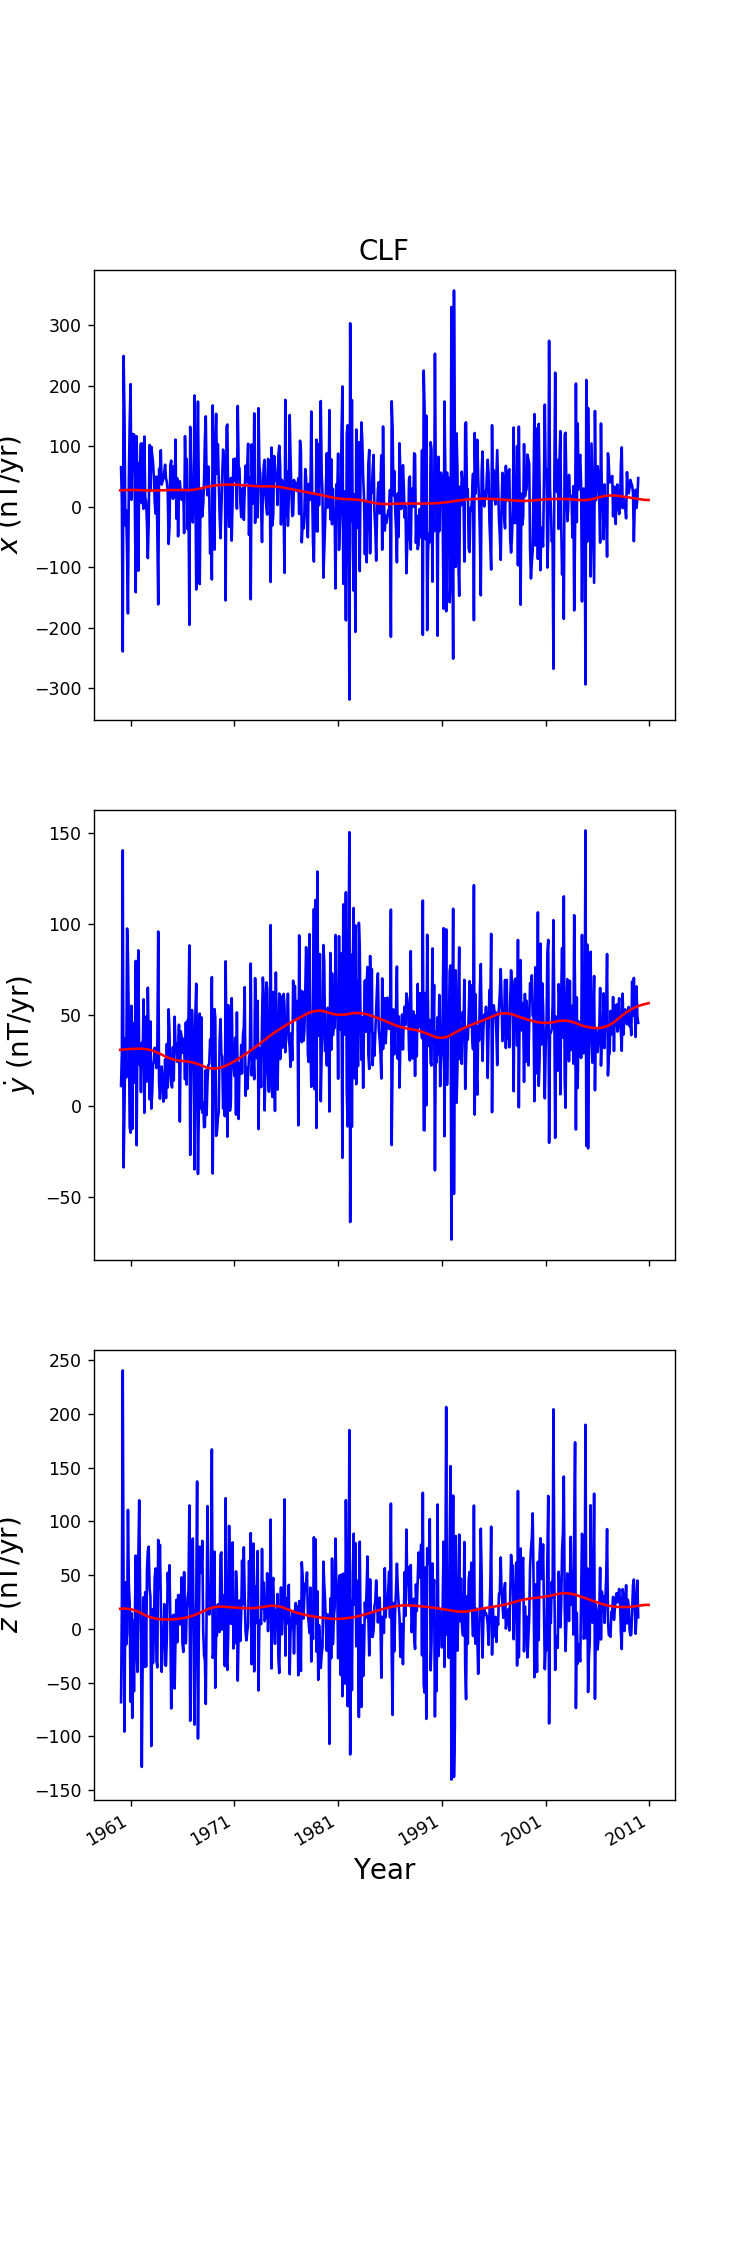

<IPython.core.display.Javascript object>


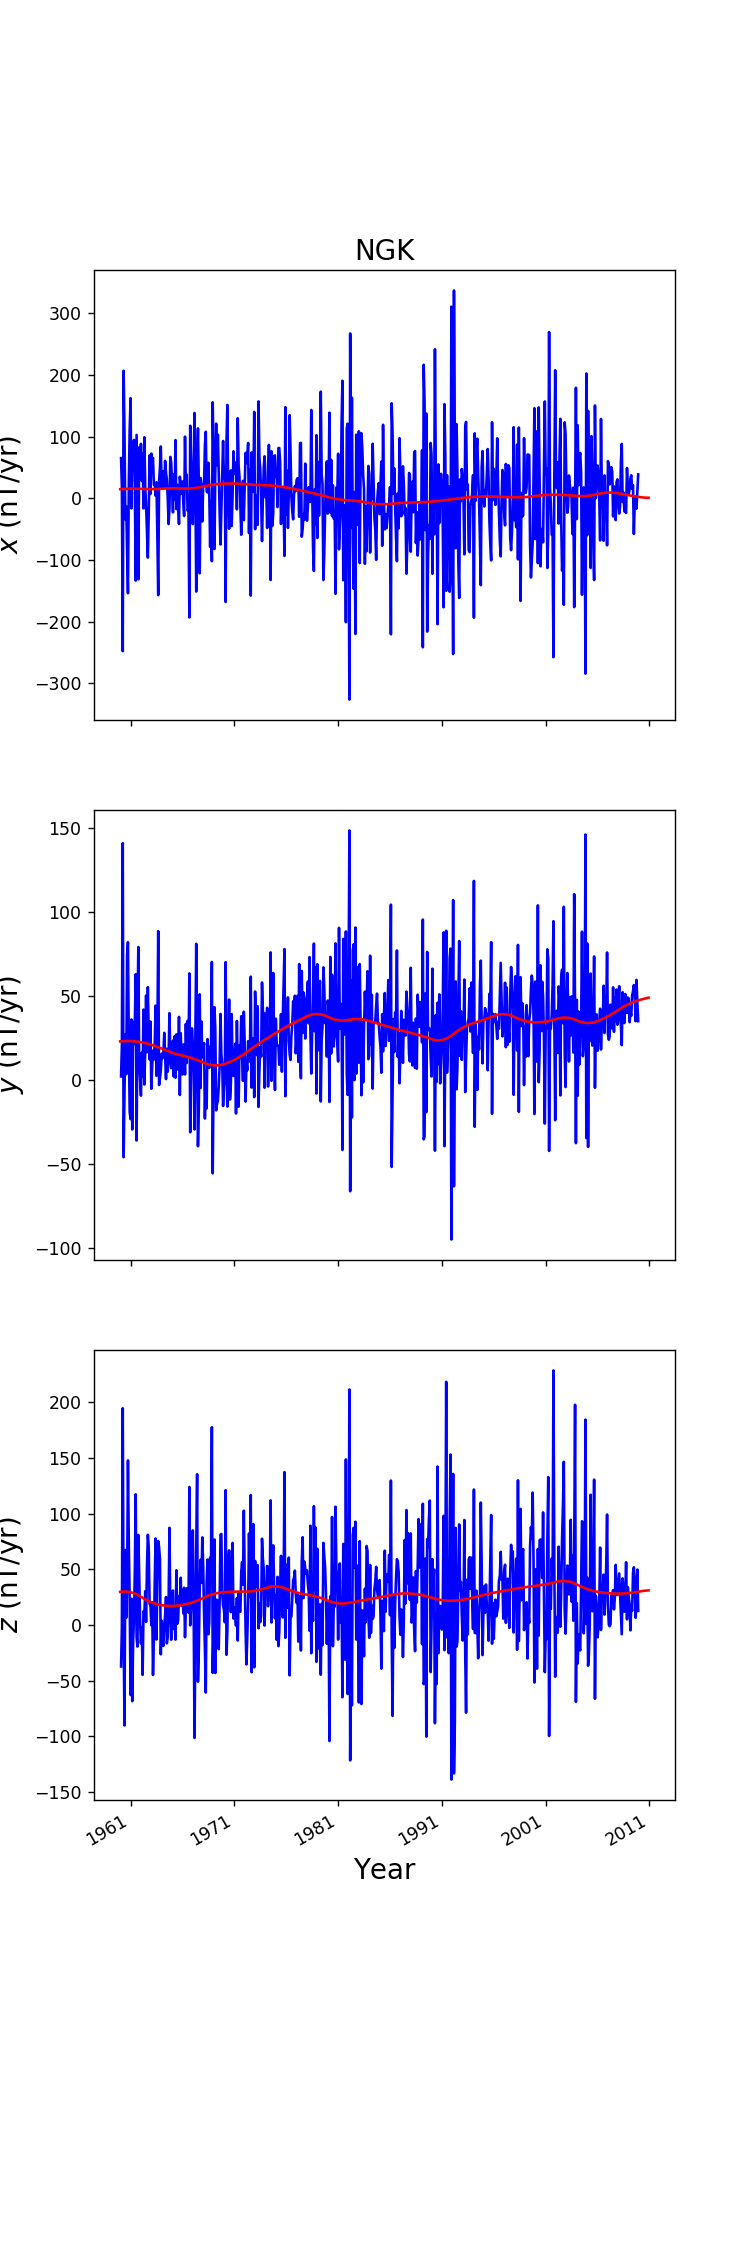

<IPython.core.display.Javascript object>


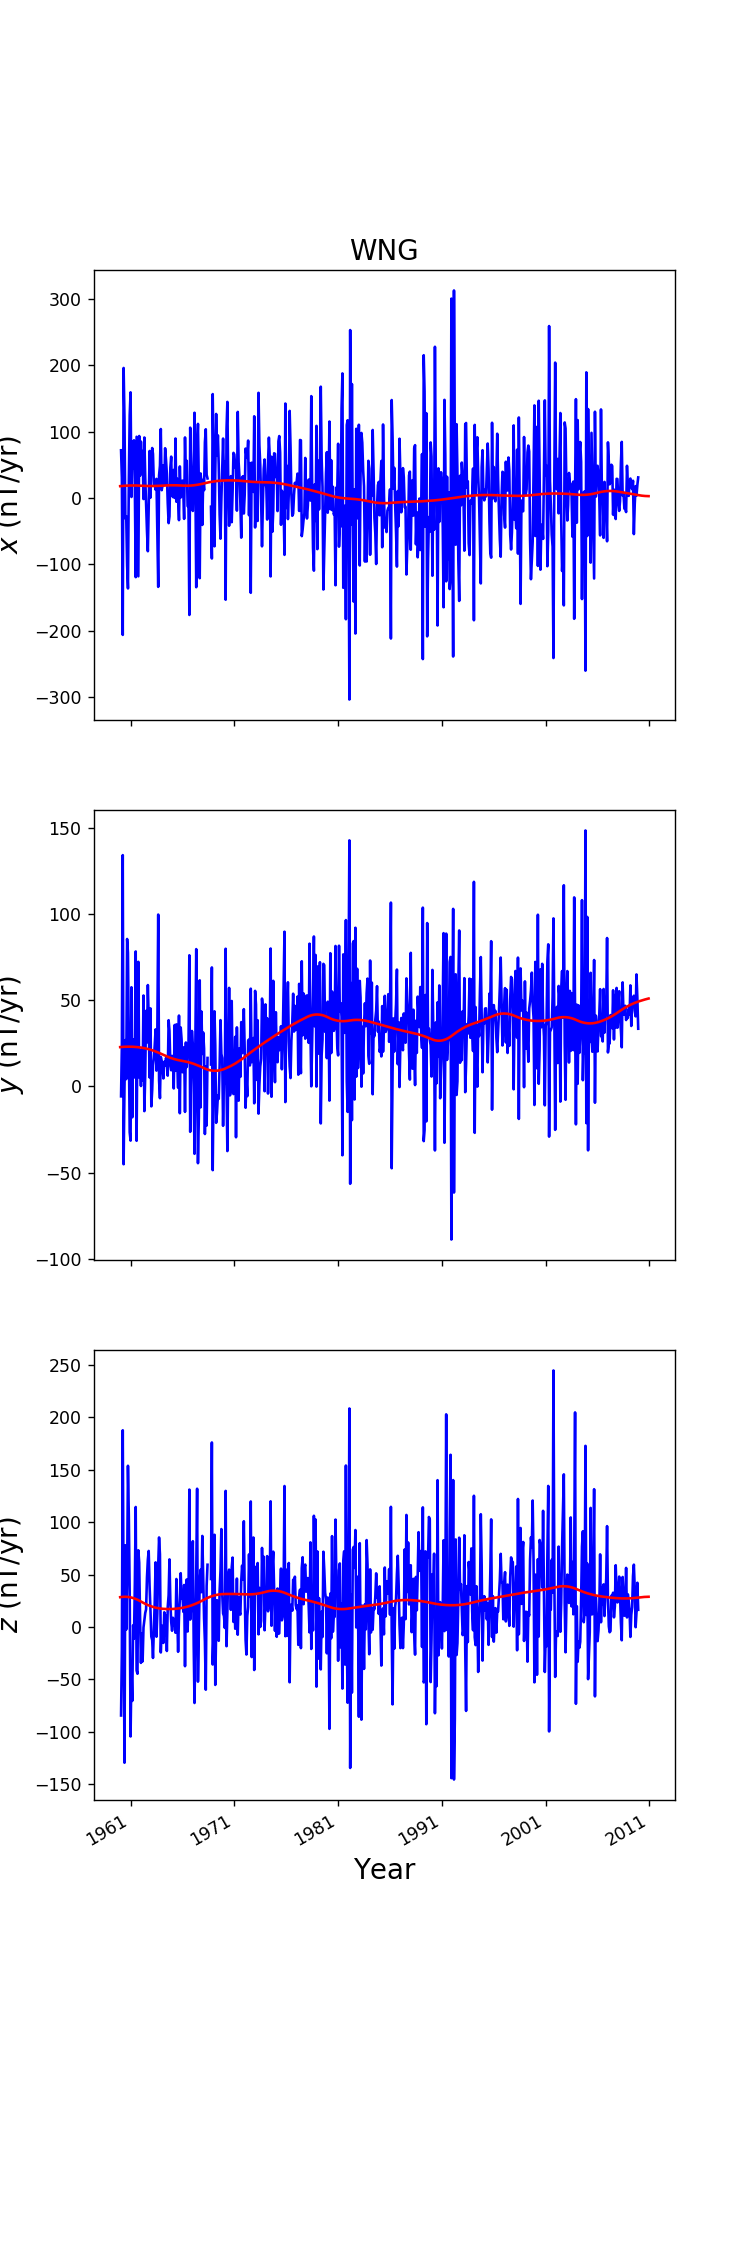

In [13]:
for observatory in observatory_list:
    fig = svplots.plot_sv(dates=dates, sv=obs_data.filter(regex=observatory),
                    model=model_sv_data.filter(regex=observatory),
                    fig_size=(6, 18), font_size=10, label_size=16, plot_legend=False,
                    obs=observatory, model_name='COV-OBS')

# Outlier detection

Optionally remove spikes in the data before denoising. Large outliers can affect the denoising process so better to remove them beforehand for some series (i.e. at high latitude observatories).

<IPython.core.display.Javascript object>


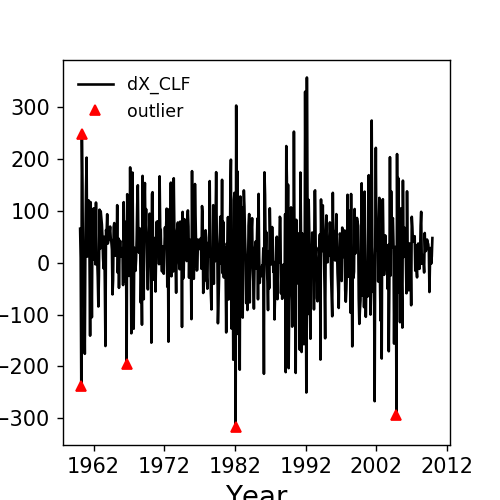

<IPython.core.display.Javascript object>


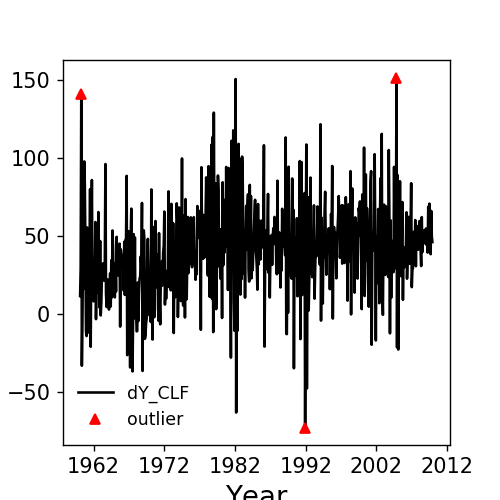

<IPython.core.display.Javascript object>


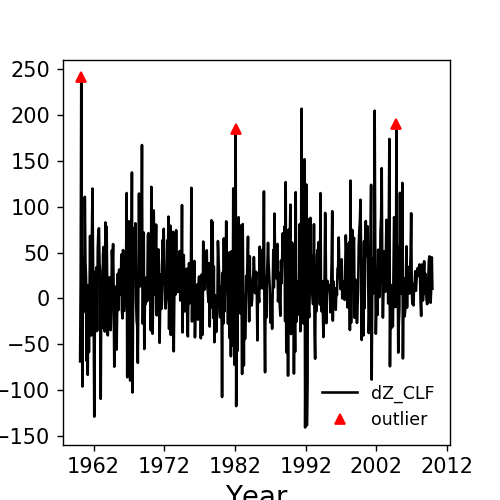

<IPython.core.display.Javascript object>


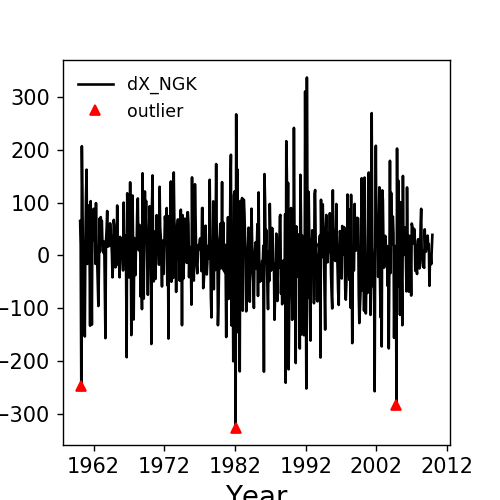

<IPython.core.display.Javascript object>


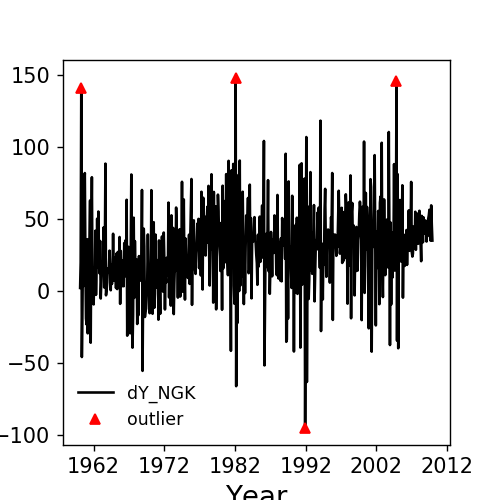

<IPython.core.display.Javascript object>


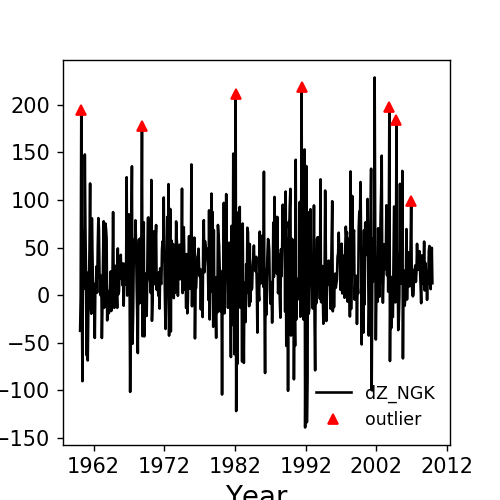

<IPython.core.display.Javascript object>


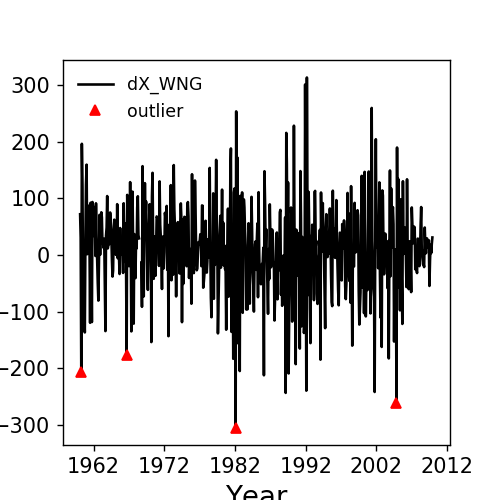

<IPython.core.display.Javascript object>


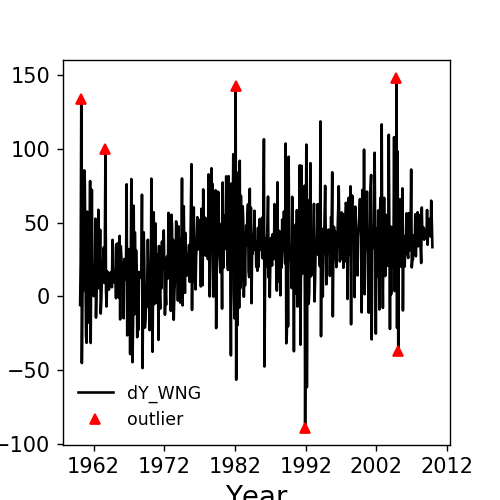

<IPython.core.display.Javascript object>


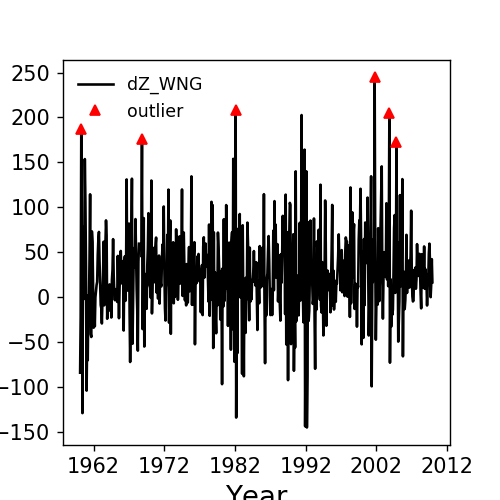

In [14]:
obs_data.drop(['date'], axis=1, inplace=True)
for column in obs_data:    
    obs_data[column] = denoise.detect_outliers(dates=dates, signal=obs_data[column], obs_name=column,
                                               threshold=4,
                                               window_length=96, plot_fig=True, fig_size=(4,4))
obs_data.insert(0, 'date', dates)

# External noise removal

Compute the residuals and use the eigenvalues/vectors of the covariance matrix to remove unmodelled external signal (Wardinski & Holme, 2011)

In [15]:
residuals = svtools.calculate_residuals(obs_data=obs_data, model_data=model_sv_data)

In [16]:
model_sv_data.drop(['date'], axis=1, inplace=True)
obs_data.drop(['date'], axis=1, inplace=True)

In [56]:
denoised, proxy, eigenvals, eigenvecs, projected_residuals, corrected_residuals = denoise.eigenvalue_analysis(
    dates=dates, obs_data=obs_data, model_data=model_sv_data, residuals=residuals,
    proxy_number=3)

# Denoised SV plots

Plots showing the original SV data, the denoised data (optionally with a running average) and the field model predictions.

<IPython.core.display.Javascript object>


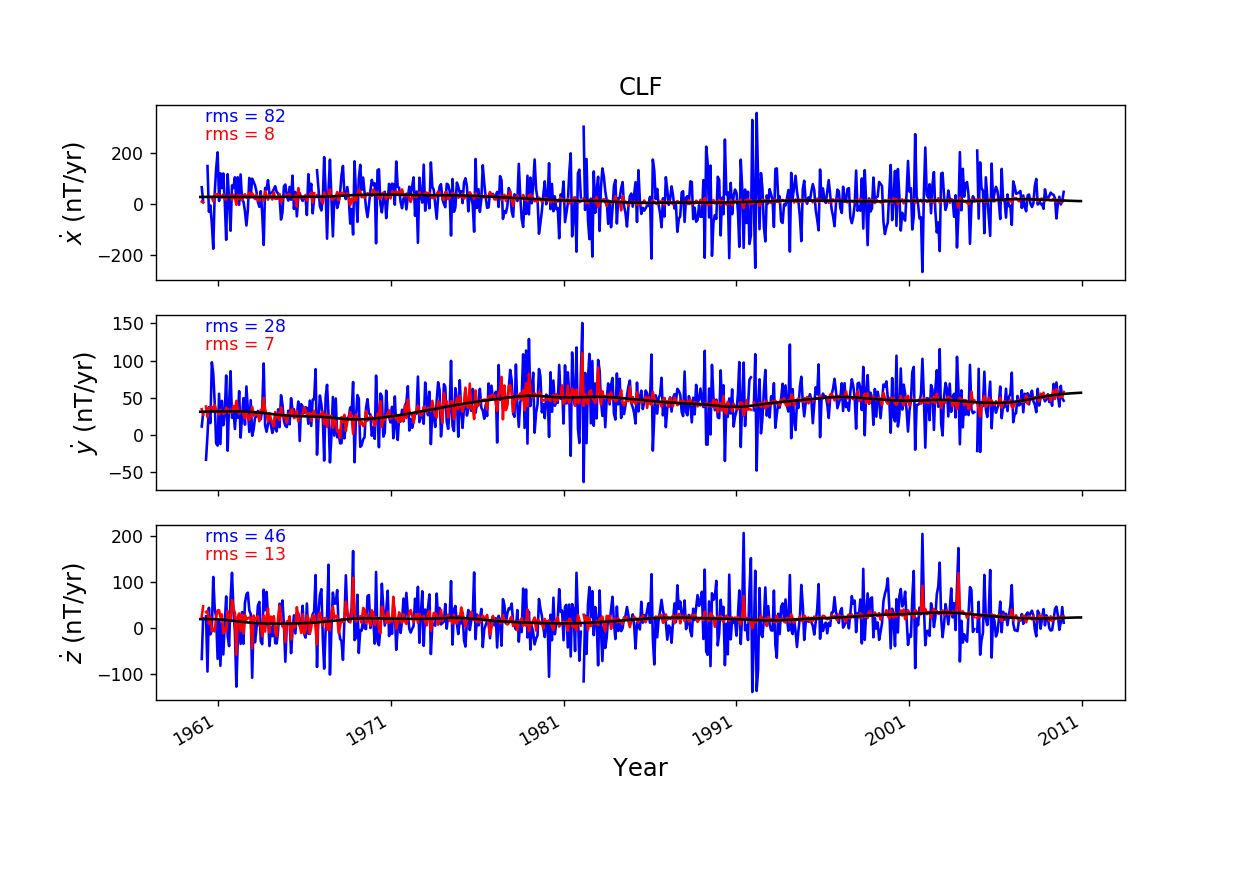

<IPython.core.display.Javascript object>


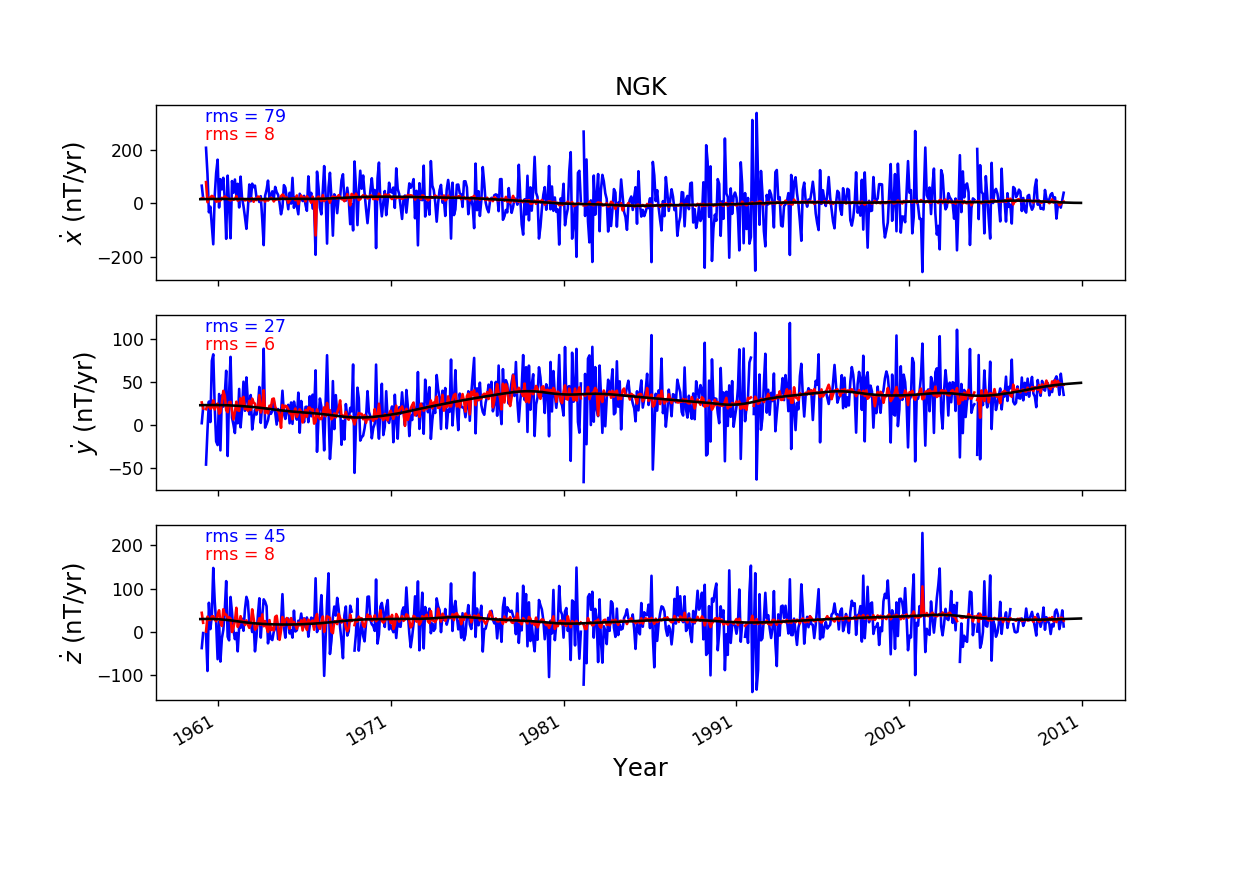

<IPython.core.display.Javascript object>


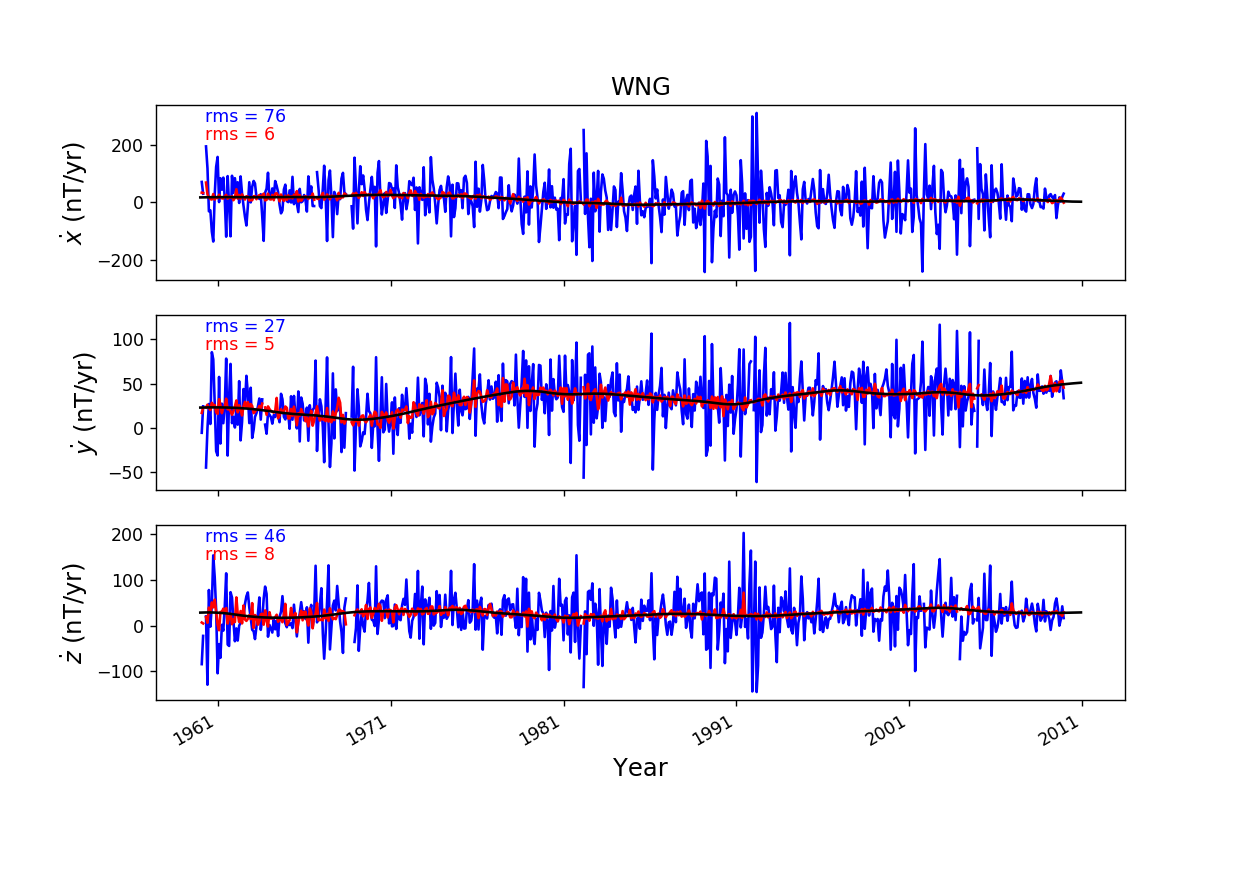

In [57]:
for observatory in observatory_list:
    xratio, yratio, zratio = svplots.plot_sv_comparison(dates=dates, denoised_sv=denoised.filter(regex=observatory),
        residuals=residuals.filter(regex=observatory),
        corrected_residuals = corrected_residuals.filter(regex=observatory),
        noisy_sv=obs_data.filter(regex=observatory), model=model_sv_data.filter(regex=observatory),
        model_name='COV-OBS',
        fig_size=(10, 7), font_size=10, label_size=14, obs=observatory, plot_rms=True)

Plots showing the denoised data (optionally with a running average) and the field model predictions.

<IPython.core.display.Javascript object>


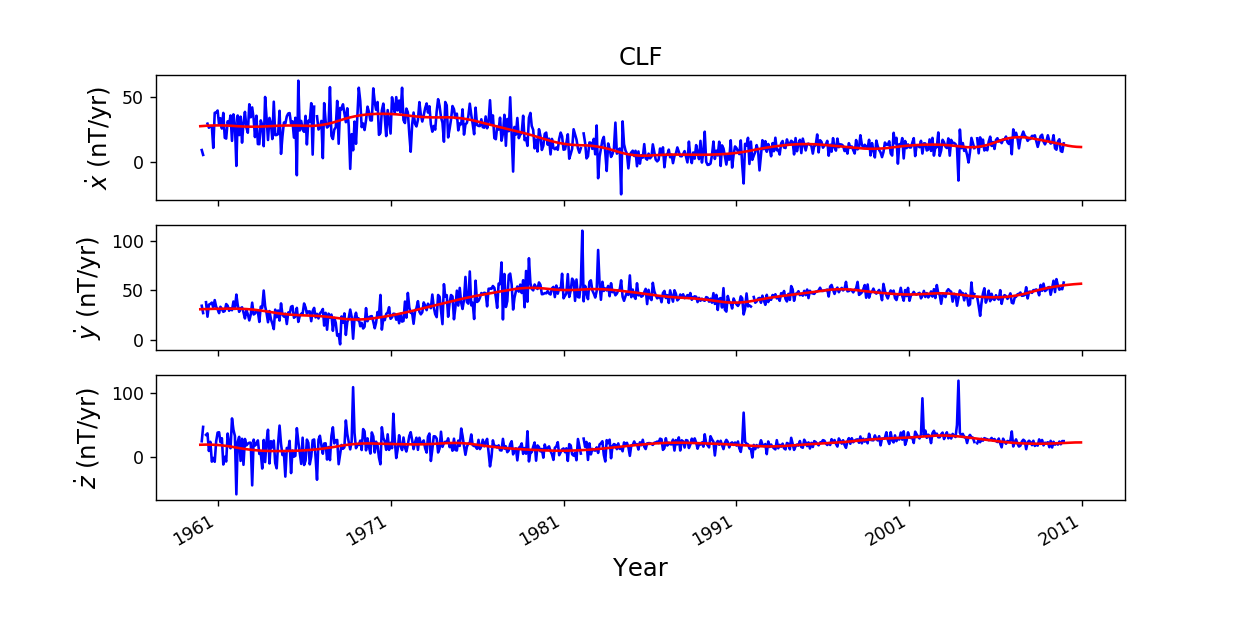

<IPython.core.display.Javascript object>


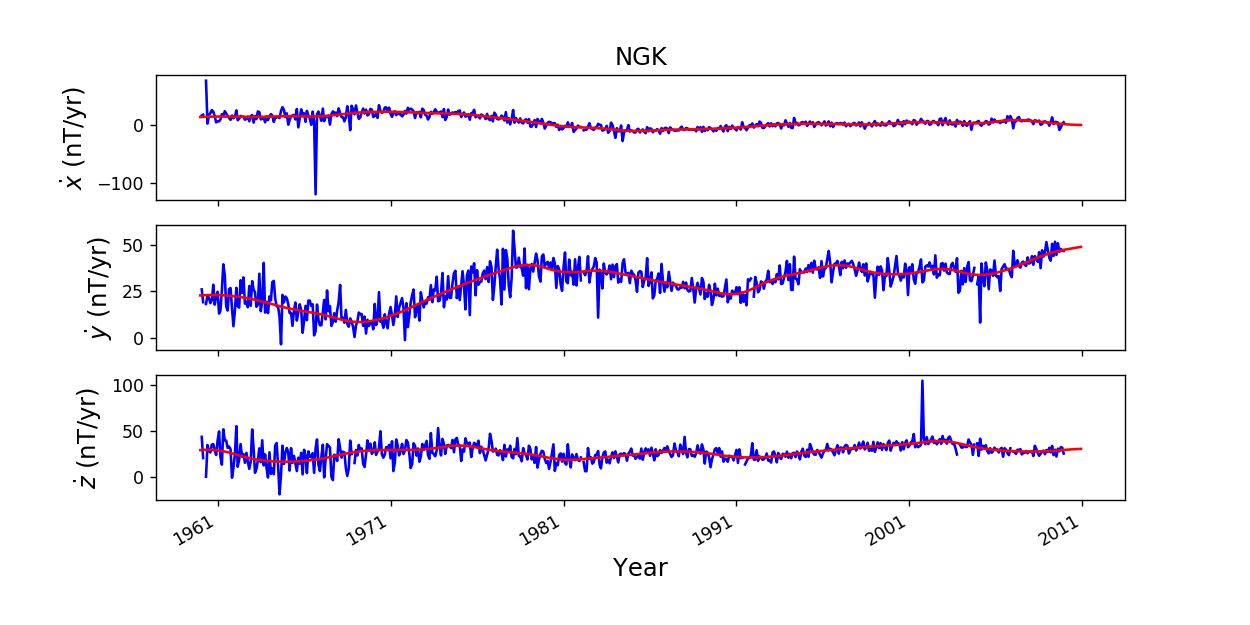

<IPython.core.display.Javascript object>


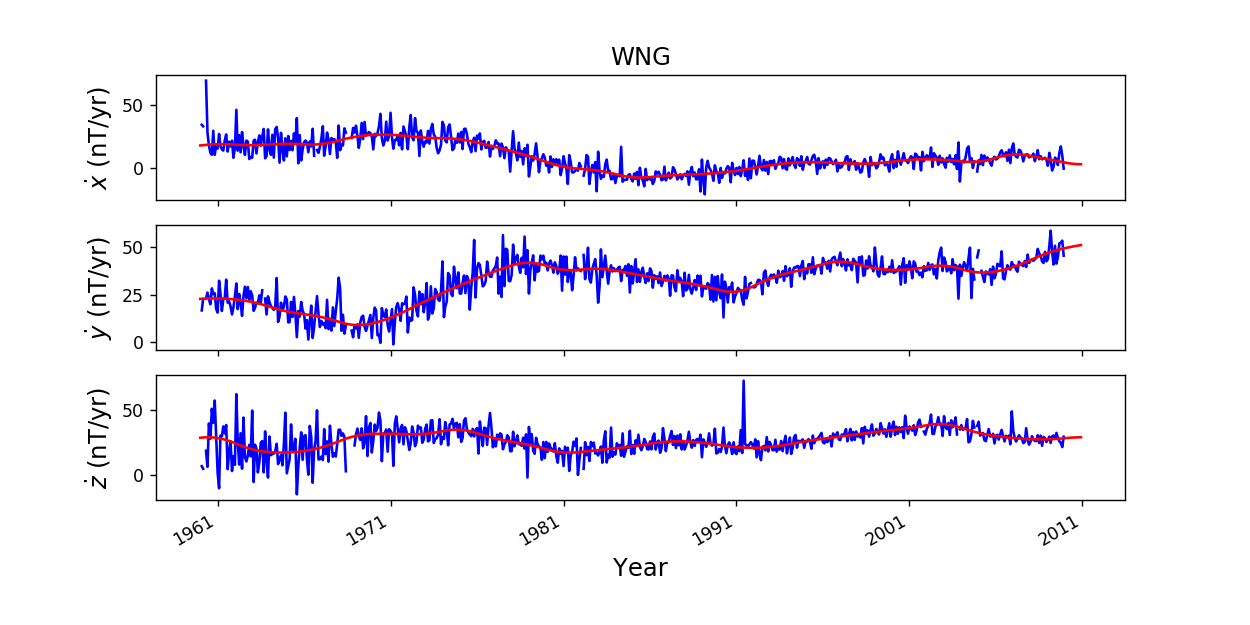

In [58]:
for observatory in observatory_list:
    svplots.plot_sv(dates=dates, sv=denoised.filter(regex=observatory), model=model_sv_data.filter(regex=observatory),
                    fig_size=(10, 5), font_size=10, label_size=14, plot_legend=False, obs=observatory, model_name='COV-OBS')

# Plot proxy signal, eigenvalues and eigenvectors

Compare the proxy signal used to denoise the data with the Dst index, measures the intensity of the equatorial electrojet (the "ring current"). Both signals are reduced to zero-mean and unit variance (z-score).

In [59]:
dst_file = '../../AuxData/dst_fdmm.csv'

<IPython.core.display.Javascript object>


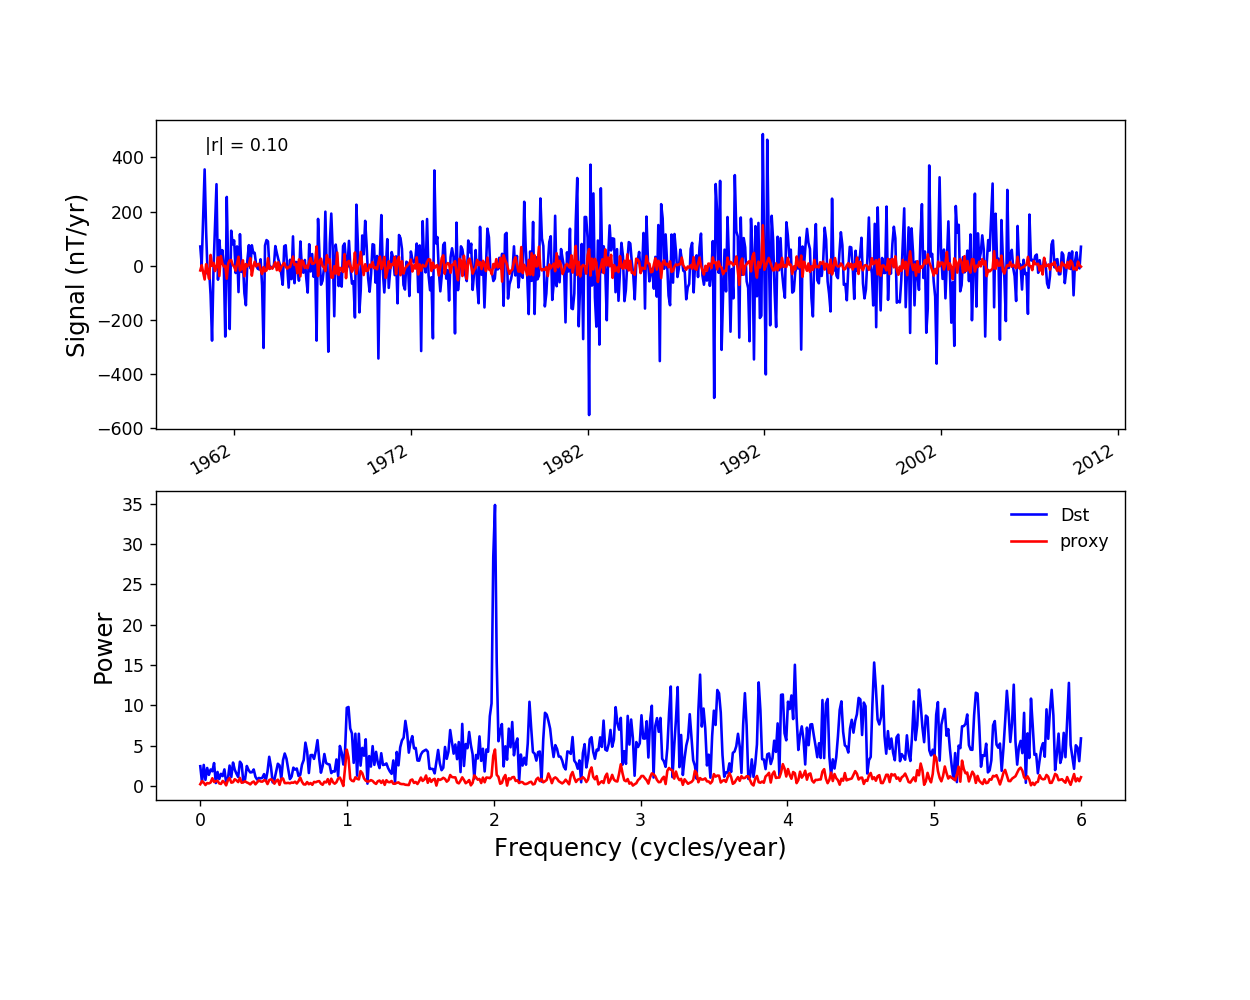

In [60]:
svplots.plot_index_dft(index_file=dst_file, dates=denoised.date, signal=projected_residuals[:,2], fig_size=(10, 8), font_size=10,
                       label_size=14, plot_legend=True, index_name='Dst')

In [61]:
third = pd.DataFrame(projected_residuals[:,2])

<IPython.core.display.Javascript object>


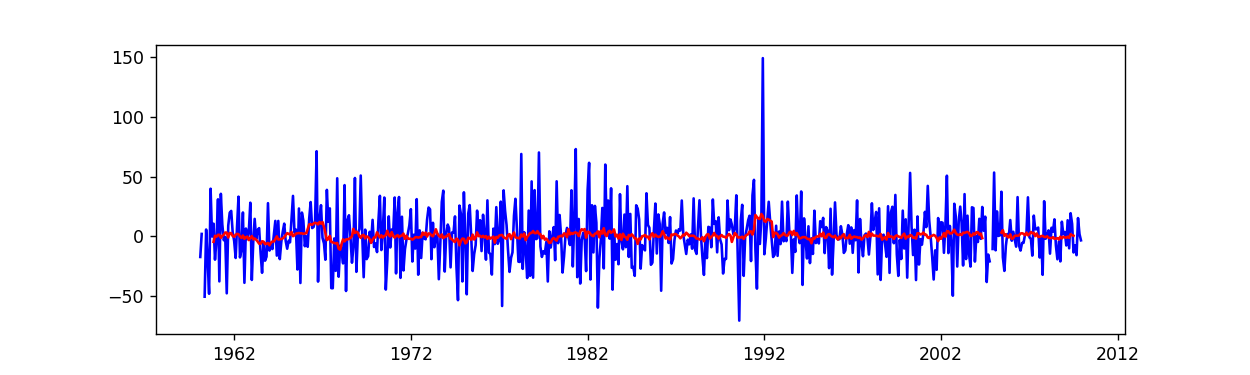

In [65]:
plt.figure(figsize=(10,3))
plt.plot(dates, third, 'b')
plt.plot(dates, third.rolling(window=12, center=True).mean(), 'r')

Plot the eigenvalues of the covariance matrix of the residuals

<IPython.core.display.Javascript object>


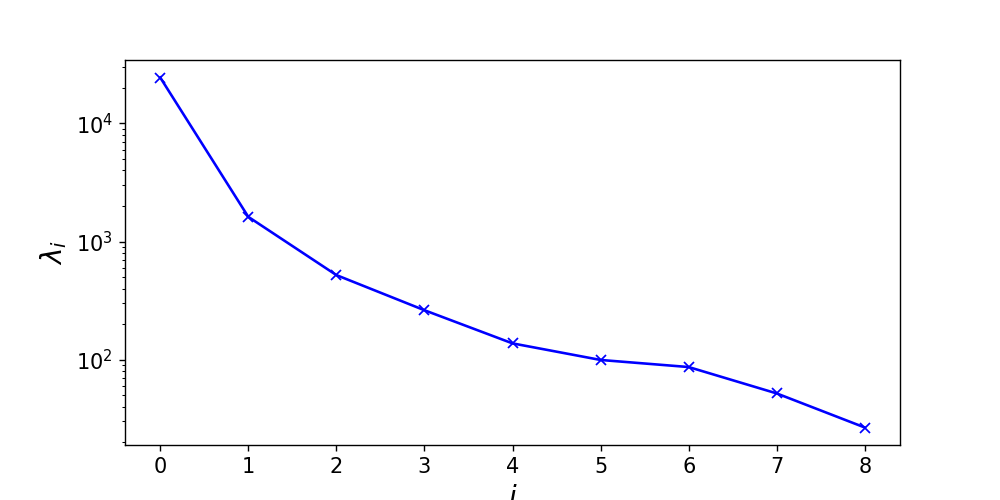

In [63]:
svplots.plot_eigenvalues(values=eigenvals, font_size=12, label_size=16, fig_size=(8, 4))

Plot the three eigenvectors corresponding to the three largest eigenvalues. The noisiest direction (used to denoise in this example) is mostly X, with some Z, which is consistent with the ring current for European observatories. The second noisiest direction (also used to denoise in this example) is predominantly Z, with some X, which is again consistent with rind current directions. However, the third noisiest direction is a coherent Y signal across Europe, which does not correspond to a known direction of external signal. We did not remove this direction during denoising as it could be a real internal field variation that is not captured by the field model.

<IPython.core.display.Javascript object>


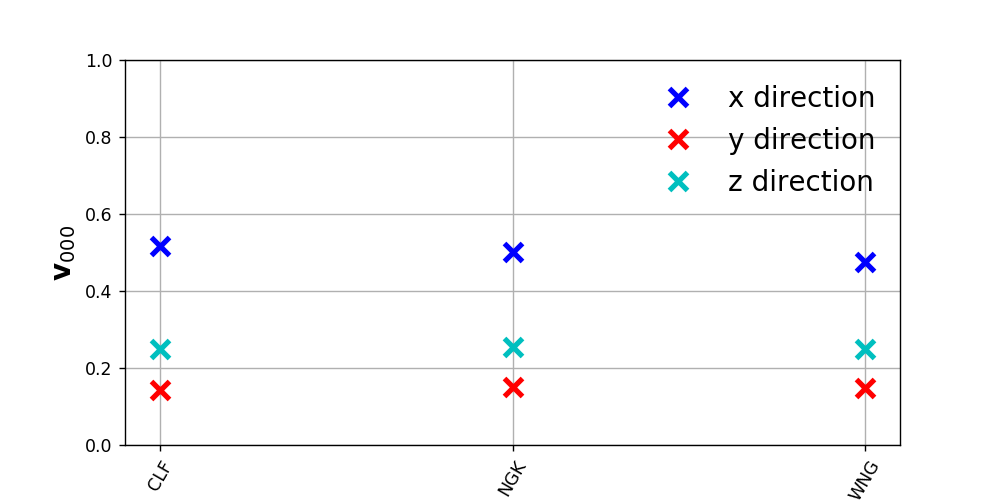

<IPython.core.display.Javascript object>


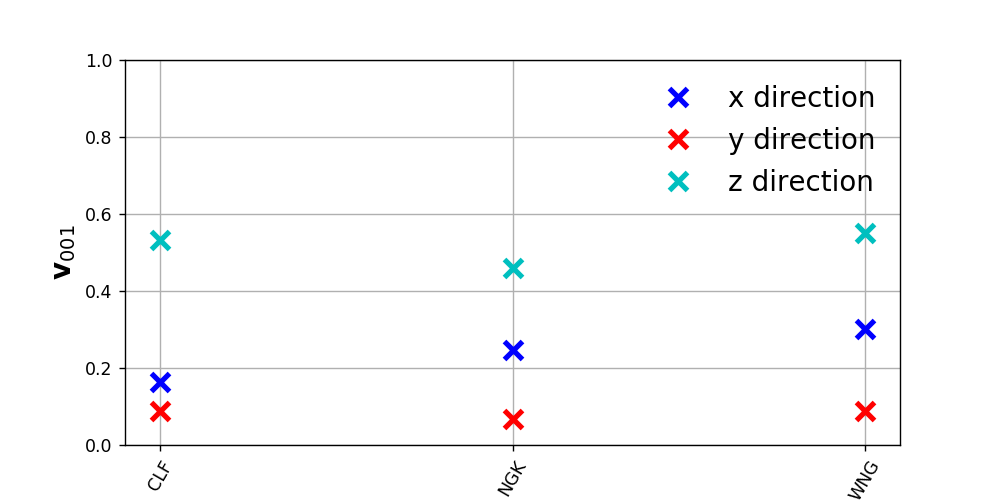

<IPython.core.display.Javascript object>


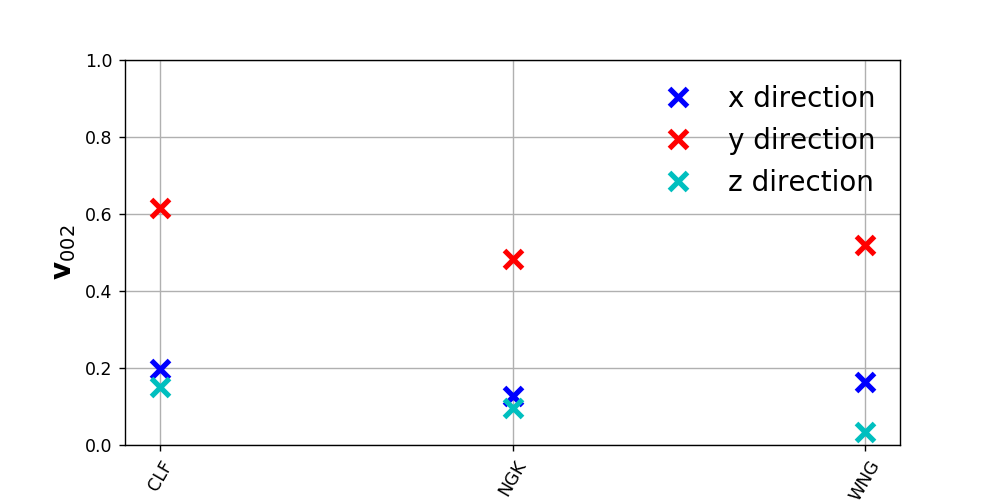

In [64]:
svplots.plot_eigenvectors(obs_names=observatory_list, eigenvecs=eigenvecs[:,0:3], fig_size=(8, 4),
                          font_size=10, label_size=16)

# Outlier detection

Remove remaining spikes in the time series.

In [24]:
denoised.drop(['date'], axis=1, inplace=True)
for column in denoised:
    denoised[column] = denoise.detect_outliers(dates=dates, signal=denoised[column], obs_name=column, threshold=5,
                                               window_length=120, plot_fig=False, fig_size=(10, 3), font_size=10, label_size=14)
denoised.insert(0, 'date', dates)

# Write denoised data to file

In [25]:
for observatory in observatory_list:
    print(observatory)
    sv_data=denoised.filter(regex=observatory)
    sv_data.insert(0, 'date', dates)
    sv_data.columns = ["date", "dX", "dY", "dZ"]
    inputoutput.write_csv_data(data=sv_data, write_path=download_dir + '/denoised/european/',
                               obs_name=observatory, decimal_dates=False)

CLF
NGK
WNG


# Averaging data over Europe

Select denoised data for each SV component at all observatories

In [70]:
obs_X = denoised.filter(regex='dX')
model_X = model_sv_data.filter(regex='dX')
obs_Y = denoised.filter(regex='dY')
model_Y = model_sv_data.filter(regex='dY')
obs_Z = denoised.filter(regex='dZ')
model_Z = model_sv_data.filter(regex='dZ')

Average data and model for each component

In [71]:
mean_X = pd.DataFrame(np.mean(obs_X.values, axis=1))
mean_X.columns = ['dX']
mean_model_X = np.mean(model_X, axis=1)
mean_Y = pd.DataFrame(np.mean(obs_Y.values, axis=1))
mean_Y.columns = ['dY']
mean_model_Y = np.mean(model_Y, axis=1)
mean_Z = pd.DataFrame(np.mean(obs_Z.values, axis=1))
mean_Z.columns = ['dZ']
mean_model_Z = np.mean(model_Z, axis=1)

Remove outliers from averaged data

In [72]:
mean_X = denoise.detect_outliers(dates=dates, signal=mean_X, obs_name='X', threshold=2.5,
                                               window_length=72, plot_fig=False, fig_size=(10, 3), font_size=10, label_size=14)
mean_Y = denoise.detect_outliers(dates=dates, signal=mean_Y, obs_name='Y', threshold=2.5,
                                               window_length=72, plot_fig=False, fig_size=(10, 3), font_size=10, label_size=14)
mean_Z = denoise.detect_outliers(dates=dates, signal=mean_Z, obs_name='Z', threshold=2.5,
                                               window_length=72, plot_fig=False, fig_size=(10, 3), font_size=10, label_size=14)

Look at model predictions for all observatories, and the averaged model, to see if the average is representative of the trend at all locations

<IPython.core.display.Javascript object>


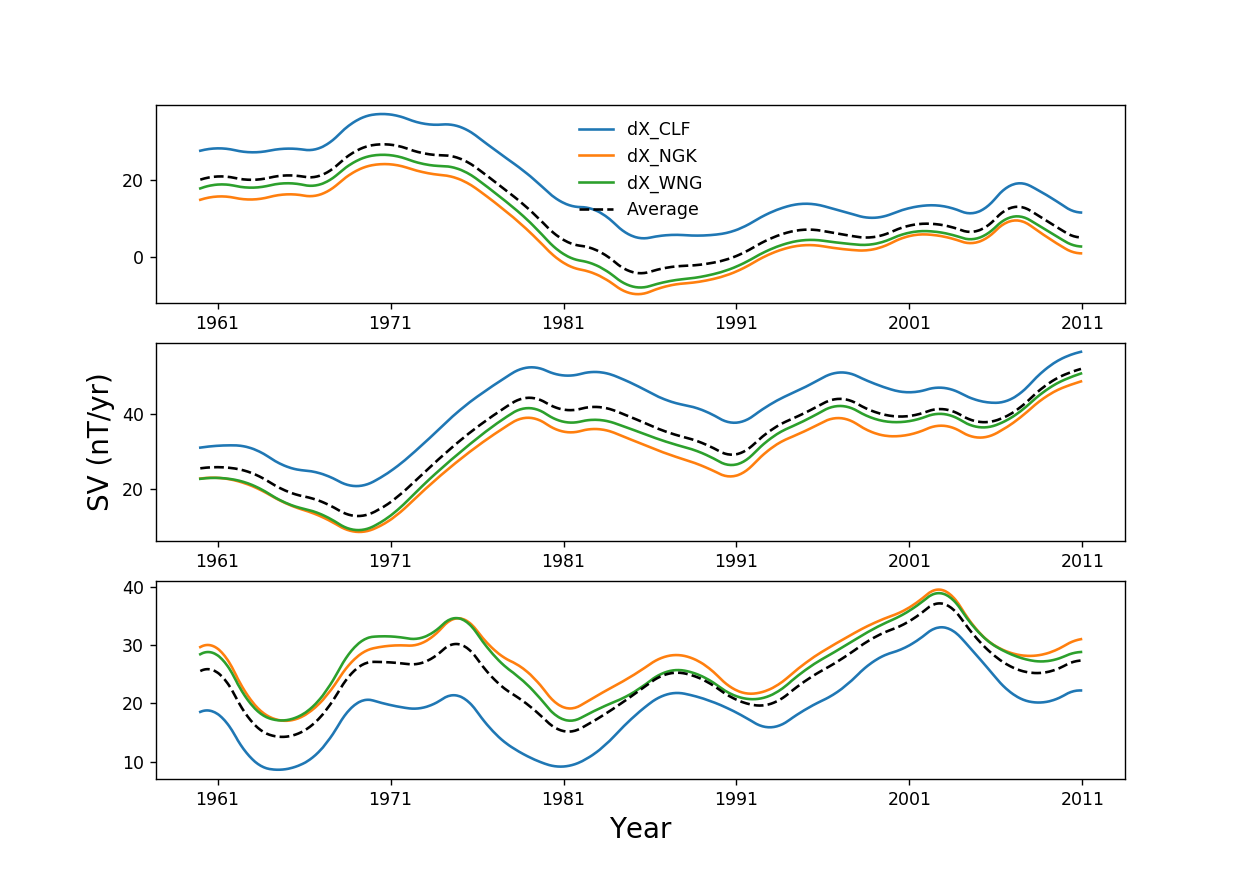

In [73]:
plt.figure(figsize=(10,7))
plt.subplot(3, 1, 1)
plt.plot(dates, model_X)
plt.plot(dates, mean_model_X, 'k--')
legend = model_X.columns.tolist()
legend.append('Average')
plt.legend(legend, frameon=False)
plt.subplot(3, 1, 2)
plt.plot(dates, model_Y)
plt.plot(dates, mean_model_Y, 'k--')
plt.ylabel('SV (nT/yr)',  fontsize=16)
plt.subplot(3, 1, 3)
plt.plot(dates, model_Z)
plt.plot(dates, mean_model_Z, 'k--')
plt.xlabel('Year',  fontsize=16)

Plot the averaged data and model

<IPython.core.display.Javascript object>


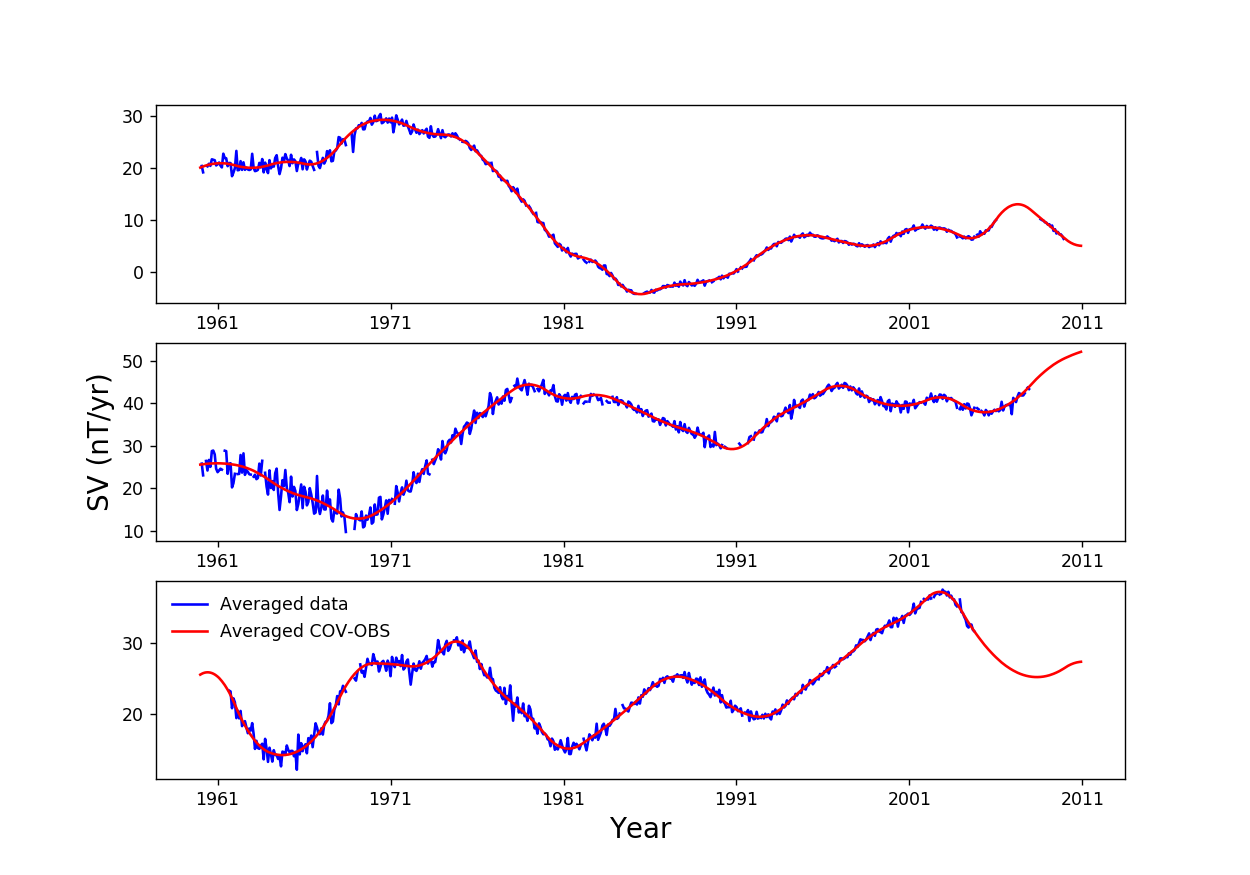

In [74]:
plt.figure(figsize=(10, 7))
plt.subplot(3,1,1)
plt.plot(dates, mean_X, 'b')
plt.plot(dates, np.mean(model_X, axis=1), 'r')
plt.subplot(3,1,2)
plt.plot(dates, mean_Y, 'b')
plt.plot(dates, np.mean(model_Y, axis=1), 'r')
plt.ylabel('SV (nT/yr)', fontsize=16)
plt.subplot(3,1,3)
plt.plot(dates, mean_Z, 'b', label='Averaged data')
plt.plot(dates, np.mean(model_Z, axis=1), 'r', label='Averaged COV-OBS')
plt.xlabel('Year',  fontsize=16)
plt.legend(loc='best', fontsize=10, frameon=False)

<IPython.core.display.Javascript object>


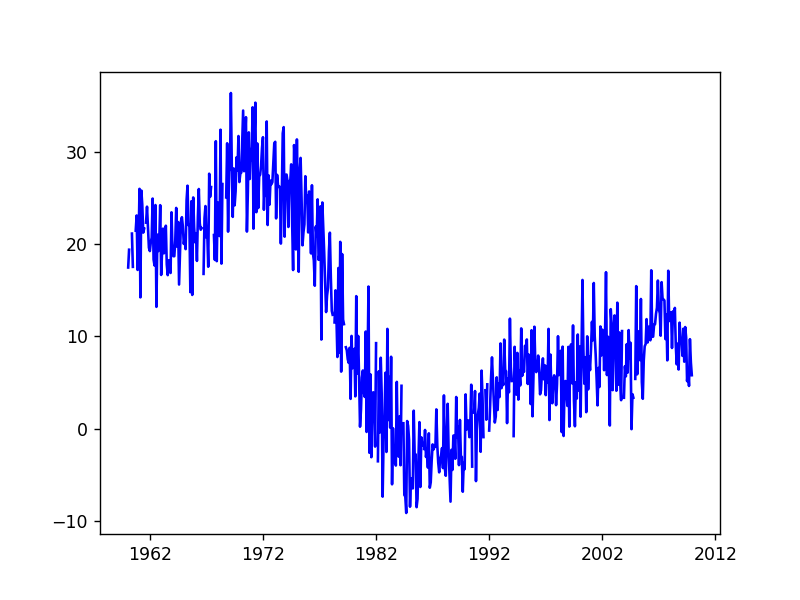

In [31]:
plt.figure()
#plt.gca().xaxis_date()
plt.plot(denoised.date, mean_X, 'b')

## Data selection using the ap index

In [44]:
# Select an observatory
observatory = 'CLF'
data_file = observatory + '.csv'
hourly_data = inputoutput.read_csv_data(
    fname=os.path.join(download_dir + 'hourly/', data_file),
    data_type='mf')
# Correct documented baseline changes
misc.correct_baseline_change(observatory=observatory,
                      field_data=hourly_data,
                      jump_data=baseline_data)
# Apply an Ap criterion to discard noisy data
hourly_data_ap = svtools.apply_Ap_threshold(obs_data=hourly_data, Ap_file='../../AuxData/ap_daily.csv',
                               threshold=7.0)
# Resample to monthly means
resampled_field_data = svtools.data_resampling(hourly_data, sampling='MS', average_date=True)
resampled_field_data_ap = svtools.data_resampling(hourly_data_ap, sampling='MS', average_date=True)
# Calculate SV from monthly field means
sv_data = svtools.calculate_sv(resampled_field_data,
                               mean_spacing=1)
sv_data_ap = svtools.calculate_sv(resampled_field_data_ap,
                               mean_spacing=1)

    observatory  jump_year  x_jump  y_jump  z_jump
115         CLF 1936-01-01    -387     -96     278
116         CLF 1957-01-01      35      -4      72
117         CLF 1968-01-01      -2     -18      11
118         CLF 1983-01-01       0      -9       1
Field jump of unknown magnitude:  1983-01-01 00:00:00


In [45]:
hourly_data

date             X            Y        Z
0      1960-01-01 00:30:00  20189.071956 -2249.316003  41817.0
1      1960-01-01 01:30:00  20187.550055 -2253.901842  41816.0
2      1960-01-01 02:30:00  20194.837876 -2260.670555  41815.0
3      1960-01-01 03:30:00  20190.266709 -2256.586403  41815.0
4      1960-01-01 04:30:00  20194.704387 -2252.922618  41816.0
5      1960-01-01 05:30:00  20195.169082 -2257.733601  41816.0
6      1960-01-01 06:30:00  20199.342477 -2256.419016  41815.0
7      1960-01-01 07:30:00  20199.673064 -2253.481408  41815.0
8      1960-01-01 08:30:00  20199.207354 -2248.669608  41813.0
9      1960-01-01 09:30:00  20194.502084 -2245.762485  41810.0
10     1960-01-01 10:30:00  20183.636372 -2243.949904  41809.0
11     1960-01-01 11:30:00  20180.395706 -2254.879835  41808.0
12     1960-01-01 12:30:00  20181.718388 -2269.891338  41806.0
13     1960-01-01 13:30:00  20178.471180 -2271.901031  41808.0
14     1960-01-01 14:30:00  20173.702780 -2269.576878  41814.0
15     1960-01-01 15:30:00  20172.775680 -2268.877452  41815.0
16     1960-01-01 16:30:00  20173.240920 -2264.770196  41820.0
17     1960-01-01 17:30:00  20177.945093 -2258.764280  41821.0
18     1960-01-01 18:30:00  20181.257150 -2256.165752  41821.0
19     1960-01-01 19:30:00  20178.804620 -2251.134490  41820.0
20     1960-01-01 20:30:00  20181.983798 -2249.708737  41820.0
21     1960-01-01 21:30:00  20183.438902 -2245.711075  41818.0
22     1960-01-01 22:30:00  20184.498514 -2245.235460  41817.0
23     1960-01-01 23:30:00  20184.432670 -2245.822544  41815.0
24     1960-01-02 00:30:00  20184.103197 -2248.757936  41815.0
25     1960-01-02 01:30:00  20185.096949 -2248.869550  41815.0
26     1960-01-02 02:30:00  20186.754503 -2252.028554  41815.0
27     1960-01-02 03:30:00  20186.490237 -2254.377141  41813.0
28     1960-01-02 04:30:00  20189.140638 -2257.648887  41816.0
29     1960-01-02 05:30:00  20193.115463 -2258.096960  41817.0
...                    ...           ...          ...      ...
438282 2009-12-30 18:30:00  21133.000000  -216.000000  42744.0
438283 2009-12-30 19:30:00  21134.000000  -216.000000  42744.0
438284 2009-12-30 20:30:00  21134.000000  -216.000000  42744.0
438285 2009-12-30 21:30:00  21134.000000  -215.000000  42744.0
438286 2009-12-30 22:30:00  21132.000000  -215.000000  42744.0
438287 2009-12-30 23:30:00  21133.000000  -216.000000  42744.0
438288 2009-12-31 00:30:00  21133.000000  -217.000000  42744.0
438289 2009-12-31 01:30:00  21133.000000  -218.000000  42744.0
438290 2009-12-31 02:30:00  21133.000000  -220.000000  42744.0
438291 2009-12-31 03:30:00  21133.000000  -220.000000  42744.0
438292 2009-12-31 04:30:00  21135.000000  -221.000000  42744.0
438293 2009-12-31 05:30:00  21136.000000  -218.000000  42744.0
438294 2009-12-31 06:30:00  21137.000000  -216.000000  42743.0
438295 2009-12-31 07:30:00  21139.000000  -213.000000  42743.0
438296 2009-12-31 08:30:00  21138.000000  -209.000000  42741.0
438297 2009-12-31 09:30:00  21135.000000  -210.000000  42737.0
438298 2009-12-31 10:30:00  21131.000000  -214.000000  42737.0
438299 2009-12-31 11:30:00  21129.000000  -219.000000  42740.0
438300 2009-12-31 12:30:00  21130.000000  -223.000000  42741.0
438301 2009-12-31 13:30:00  21128.000000  -225.000000  42744.0
438302 2009-12-31 14:30:00  21131.000000  -225.000000  42745.0
438303 2009-12-31 15:30:00  21134.000000  -223.000000  42744.0
438304 2009-12-31 16:30:00  21134.000000  -220.000000  42745.0
438305 2009-12-31 17:30:00  21132.000000  -219.000000  42745.0
438306 2009-12-31 18:30:00  21130.000000  -216.000000  42745.0
438307 2009-12-31 19:30:00  21127.000000  -215.000000  42745.0
438308 2009-12-31 20:30:00  21126.000000  -213.000000  42745.0
438309 2009-12-31 21:30:00  21128.000000  -213.000000  42745.0
438310 2009-12-31 22:30:00  21129.000000  -214.000000  42745.0
438311 2009-12-31 23:30:00  21129.000000  -216.000000  42745.0

[438312 rows x 4 columns]

<IPython.core.display.Javascript object>


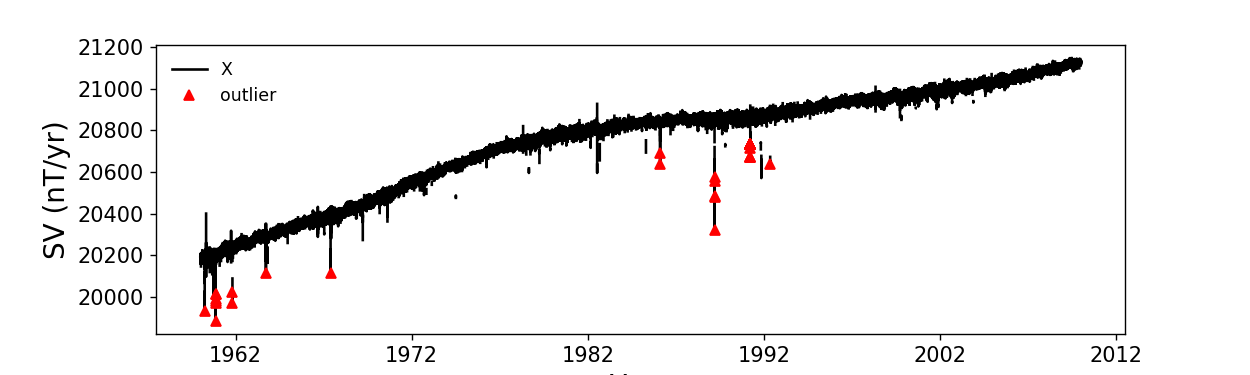

<IPython.core.display.Javascript object>


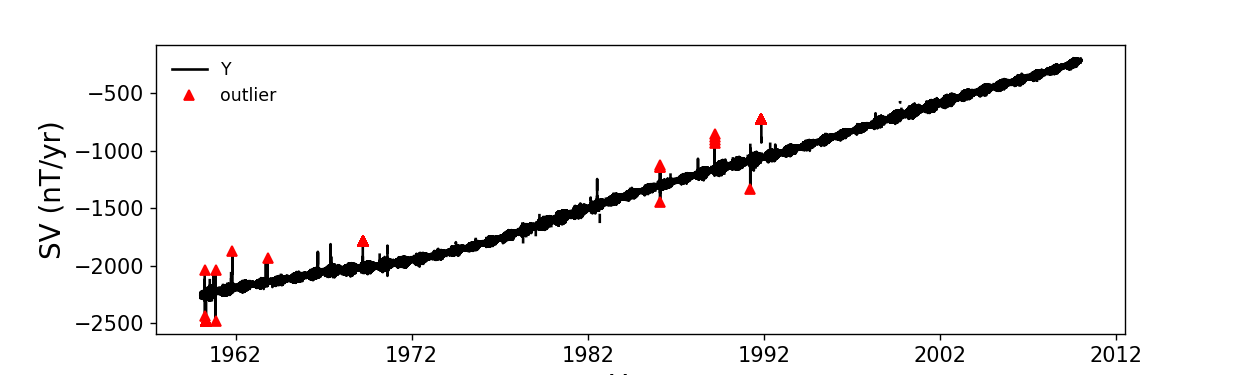

<IPython.core.display.Javascript object>


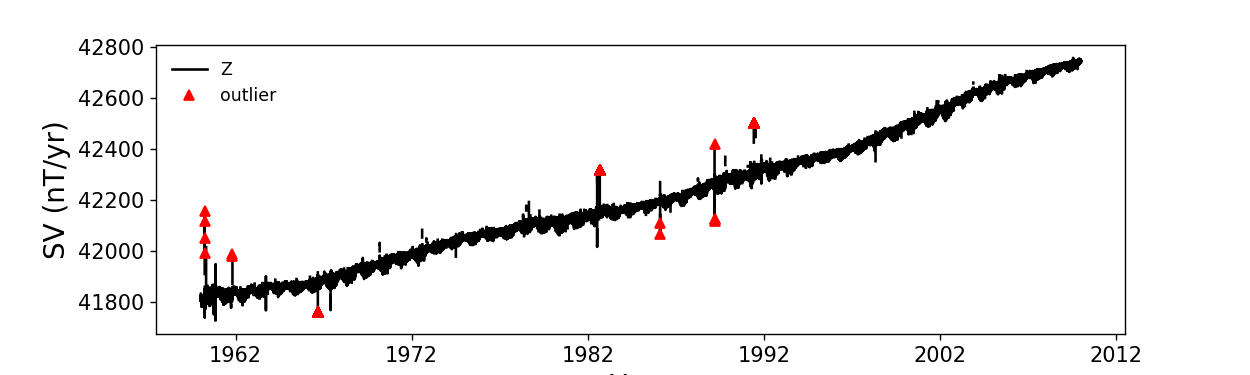

In [34]:
d = hourly_data_ap.date
hourly_data_ap.drop(['date'], axis=1, inplace=True)
for column in hourly_data_ap:    
    hourly_data_ap[column] = denoise.detect_outliers(dates=d, signal=hourly_data_ap[column], obs_name=column,
                                               threshold=15,
                                               window_length=2400, plot_fig=True, fig_size=(10,3))
hourly_data_ap.insert(0, 'date', d)

Calculate the percentage of data remaining after applying the threshold

In [46]:
hourly_data_ap.X.count()/hourly_data.X.count() * 100

37.870423409504291

Compare the hourly magnetic field data before and after appyling the ap threshold

<IPython.core.display.Javascript object>


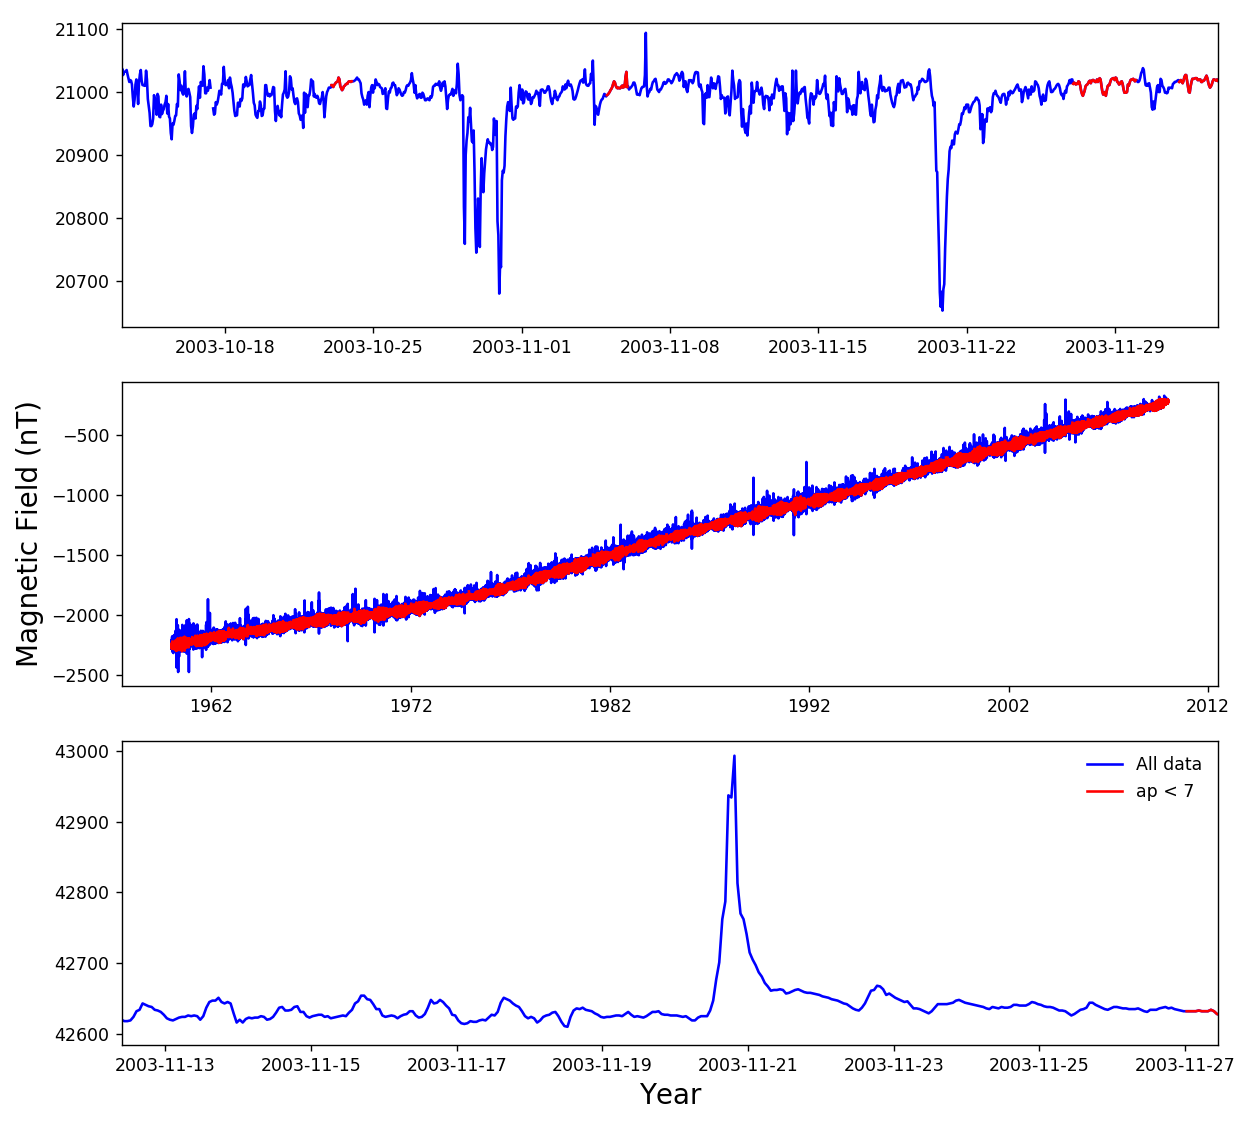

In [47]:
plt.figure(figsize=(10, 9))
plt.subplot(3, 1, 1)
plt.plot(hourly_data.date, hourly_data.X, 'b')
plt.plot(hourly_data.date, hourly_data_ap.X, 'r')
plt.subplot(3, 1, 2)
plt.plot(hourly_data.date, hourly_data.Y, 'b')
plt.plot(hourly_data.date, hourly_data_ap.Y, 'r')
plt.ylabel('Magnetic Field (nT)', fontsize=16)
plt.subplot(3, 1, 3)
plt.plot(hourly_data.date, hourly_data.Z, 'b', label='All data')
plt.plot(hourly_data.date, hourly_data_ap.Z, 'r', label='ap < 7')
plt.xlabel('Year', fontsize=16)
plt.legend(frameon=False)
plt.tight_layout()

Compare the SV obtained when calculated using all hourly data and hourly the ap threshold applied

<IPython.core.display.Javascript object>


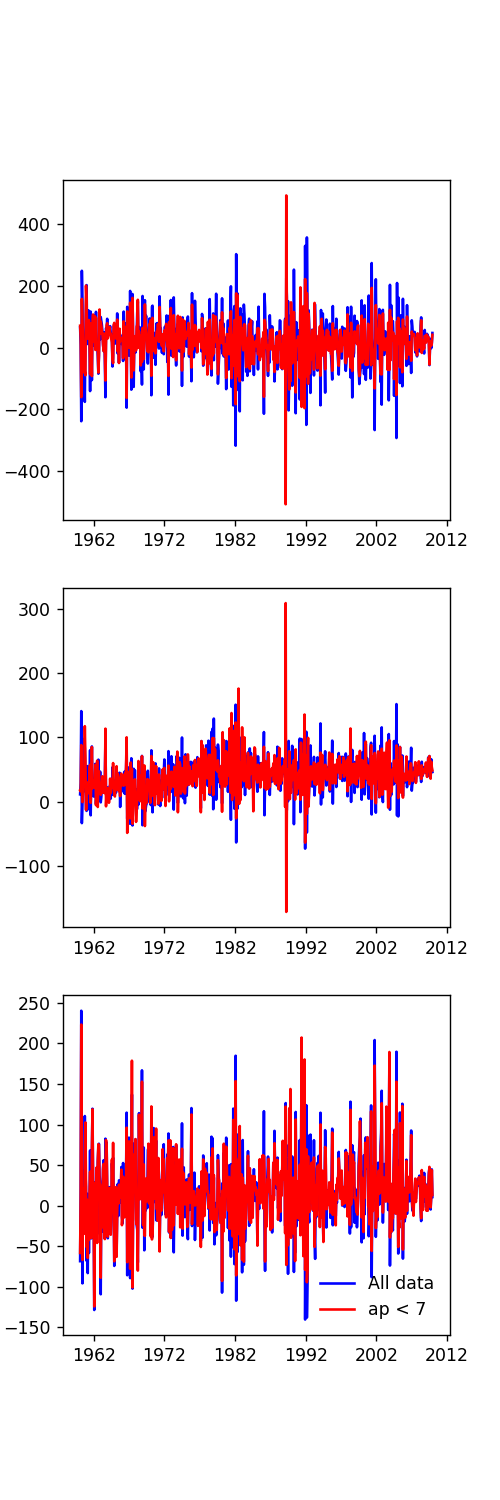

In [42]:
plt.figure(figsize=(4, 12))
plt.subplot(3, 1, 1)
plt.plot(sv_data.date, sv_data.dx, 'b')
plt.plot(sv_data_ap.date, sv_data_ap.dx, 'r')
plt.subplot(3, 1, 2)
plt.plot(sv_data.date, sv_data.dy, 'b')
plt.plot(sv_data_ap.date, sv_data_ap.dy, 'r')
plt.ylabel('SV (nT/yr)', fontsize=16)
plt.subplot(3, 1, 3)
plt.plot(sv_data.date, sv_data.dz, 'b', label='All data')
plt.plot(sv_data.date, sv_data_ap.dz, 'r', label = 'ap < 7')
plt.gca().xaxis_date()
plt.ylabel('Year', fontsize=16)
plt.legend(frameon=False)